![example](images/director_shot.jpeg)

# Is It Time For A Sci-Fi Summer Adventure?

**Authors:** Doug, Carlos, Michael
***

## Overview

* What Better Way To Launch Microsoft's New Movie Other Than An Original Blockbuster Series?! We sift through the data to find out when is the best time to produce a film and what type of film people are currently enjoying. This project presents analysis of past movie outcomes based on movies' budget, seasonality, and genre, and can be used to forecast future movie outcomes based on these factors. These forecasts show the strength and impact of these variables which should be considered by Microsoft.

## Business Problem

Microsoft Movie Studio will be able to make a more effective decision based on statistical analysis of several variables and their outcomes. These variables include production budget, seasonality, and genre. We decided that these were the driving factors on box office outcomes. These questions are important from a business perspective because they help optimize the probability of successful project outcomes. 
We tried to see by creating our own series, we can create more loyal and dedicated fans.
But we must do it right. We start off by looking at the seasons to see where the best times to release 
a movie are and when is a bad time to have a big release. We also looked throuh the different genres to see
what films people are going to and paying for to narrow down their intrest. With this we can target our audiance 
to see where some opportunities may have been missed!


## Data Understanding

We went through different databases and combined from Box Office Mojo, IMBD, and The-Numbers to get a better general overview of not only peoples intreest but also what time of year they were seeing these movies. Our target variables were dates and genres corresponding to the gross income from foreign and domestic movies. These data sets contained information about release dates, domestic gross, worldwide gross, budget, rating, genre, actors, actresses, and directors. We analyzed these datasets to draw several conclusions.
We used a customized dataset which combined "Box Office Mojo movie gross", "IMDB title basics", and "TheNumbers movie budgets". I found that there is a moderate positive correlation between 'Budget' and 'Domestic Gross', and 'Budget' and 'Worldwide Gross'. The statistical method used to quantify this was Pearson's correlation coefficient 'r'.
***


In [1]:
#Import all necessary packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import gzip
import csv
import numpy as np
import seaborn as sns
from matplotlib import style

In [2]:
# Load dataset 1 'bom.movie_gross' obtained from Box Office Mojo
df1 = pd.read_csv('data/zippedData/bom.movie_gross.csv.gz')
df1 = df1.rename(columns = {'title':'movie'})

# Load dataset 4 'imbd.title.basics' obtained from IMDB
df4 = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
df4 = df4.rename(columns = {'primary_title':'movie'})

# Load dataset 11 'tn.movie_budgets' from The-Numbers
df11 = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')


## Data Preparation

* First we set all our gross values and our dates into integers so that we can work with them to calculate totals from the The-Numbers dataframe then we take only the movies with budget above 1 million dollars.  

In [3]:
# Strip '$' and ',' from the dataset and convert to int64 in order to manipulate the data
df11['worldwide_gross'] = df11['worldwide_gross'].str[1:]
df11['worldwide_gross'] = df11['worldwide_gross'].str.replace(',', '').astype(np.int64)
df11['domestic_gross'] = df11['domestic_gross'].str[1:]
df11['domestic_gross'] = df11['domestic_gross'].str.replace(',', '').astype(np.int64)
df11['production_budget'] = df11['production_budget'].str[1:]
df11['production_budget'] = df11['production_budget'].str.replace(',', '').astype(np.int64)

# Filter the data to our criteria
production = df11[df11.production_budget < 1000000].index
df11.drop(production, inplace=True)
worldwide = df11[df11.worldwide_gross < 1000000].index
df11.drop(worldwide, inplace=True)
df11.set_index('movie')

,id,release_date,production_budget,domestic_gross,worldwide_gross
movie,,,,,
Avatar,1,"Dec 18, 2009",425000000,760507625,2776345279
Pirates of the Caribbean: On Stranger Tides,2,"May 20, 2011",410600000,241063875,1045663875
Dark Phoenix,3,"Jun 7, 2019",350000000,42762350,149762350
Avengers: Age of Ultron,4,"May 1, 2015",330600000,459005868,1403013963
Star Wars Ep. VIII: The Last Jedi,5,"Dec 15, 2017",317000000,620181382,1316721747
...,...,...,...,...,...
Fiza,59,"Sep 8, 2000",1000000,623791,1179462
Ajami,60,"Feb 3, 2010",1000000,621859,2721096
The Future,62,"Jul 29, 2011",1000000,568662,1239174


* Esstablishing a combined dataframe and droping values that are empty. 

In [4]:
# Merge the three dataframes together to get 'master' dataframe "BigFrame"
BigFrame = df11.merge(df1, on='movie').merge(df4, on='movie').drop\
                (columns=['tconst', 'original_title', 'start_year', 'id', 'domestic_gross_y', 'runtime_minutes'])
# Create 'month' column in order to manipute the data
BigFrame = BigFrame.drop_duplicates(subset='movie').set_index('movie')
BigFrame['month'] = BigFrame['release_date'].str[:3]
# Drop rows with missing values
BigFrame = BigFrame.dropna()
BigFrame.dropna(inplace=True)
# Final dataset has 967 rows
BigFrame['foreign_gross'] = BigFrame['foreign_gross'].str.replace(',', '')
BigFrame['foreign_gross'] = BigFrame['foreign_gross'].str.replace('.', '')
BigFrame['foreign_gross'] = BigFrame['foreign_gross'].astype(np.int64)
#Set the Foreign gross to an INT
BigFrame.year = BigFrame.year.astype(int)
#Set the Year as an INT

***

In [5]:
BigFrame.tail()

,release_date,production_budget,domestic_gross_x,worldwide_gross,studio,foreign_gross,year,genres,month
movie,,,,,,,,,
Blue Valentine,"Dec 29, 2010",1000000,9737892,16566240,Wein.,2600000,2010,"Drama,Romance",Dec
Unfriended: Dark Web,"Jul 20, 2018",1000000,8866745,16434588,BH Tilt,6300000,2018,"Crime,Horror,Mystery",Jul
The Sessions,"Oct 19, 2012",1000000,6002451,11495204,FoxS,3100000,2012,"Biography,Comedy,Drama",Oct
Martha Marcy May Marlene,"Oct 21, 2011",1000000,2981038,5438911,FoxS,548000,2011,"Drama,Mystery,Thriller",Oct
Patti Cake$,"Aug 18, 2017",1000000,800148,1471090,FoxS,682000,2017,"Drama,Music",Aug


# Gross Amount Sorting
* Isolate the gross amounts according to their corresponding genres.

In [6]:
#Isolating each gross then setting it as the index to find the corresponding genres
ForeignF = BigFrame.set_index(keys='foreign_gross')
DomesticF = BigFrame.set_index(keys='domestic_gross_x')
ForeignF['genres'] = ForeignF['genres'].str.split(',')
DomesticF['genres'] = DomesticF['genres'].str.split(',')
ForeignF = ForeignF.drop(columns=['worldwide_gross'], axis=1).drop(columns='domestic_gross_x')
Domestic = DomesticF.drop(columns=['worldwide_gross'], axis=1).drop(columns='foreign_gross')
WorldGross = BigFrame.set_index(keys='worldwide_gross').drop(columns='domestic_gross_x').drop(columns='foreign_gross')

* We went with the median over the mean due to the outlires having adverse impact on our data set. 

In [7]:
#Create a function to extract the genres from Worldwide Gross and the corresponding gross amounts. 
def getgross(g):
    listi = []
    for k, v in WorldGross['genres'].items():
        if g in v:
            listi.append(k)
    return listi
waction = getgross('Action')
wcomedy = getgross('Comedy')
wadventure = getgross('Adventure')
wthriller = getgross('Thriller')
wcrime = getgross('Crime')
wromance = getgross('Romance')
whorror = getgross('Horror')
wscifi = getgross('Sci-Fi')
wbiography = getgross('Biography')
wmystery = getgross('Mystery')
wfamily = getgross('Family')
wmusic = getgross('Music')
wdocumentary = getgross('Documentary')


'''
Find the Median of all the genres
'''

mwaction = np.median(waction)
mwcomedy = np.median(wcomedy)
mwadventure = np.median(wadventure)
mwthriller = np.median(wthriller)
mwcrime = np.median(wcrime)
mwromance = np.median(wromance)
mwhorror = np.median(whorror)
mwscifi = np.median(wscifi)
mwbiography = np.median(wbiography)
mwmystery = np.median(wmystery)
mwfamily = np.median(wfamily)
mwmusic = np.median(wmusic)
mwdocumentary = np.median(wdocumentary)

In [8]:
#Set the medians to a list for graphing
WorldGrossMed = [mwcomedy, mwaction, mwadventure, mwthriller, mwcrime, mwromance, mwhorror, mwscifi, mwbiography, mwmystery, mwfamily, mwmusic, mwdocumentary]
WorldGrossMed = list(WorldGrossMed)

In [9]:
#Create a function to extract the genres from Foreign Gross and the corresponding gross amounts. 
def getgross(g):
    listi = []
    for k, v in ForeignF['genres'].items():
        if g in v:
            listi.append(k)
    return listi

#Create variables storing the total gross amount of each genre
faction = getgross('Action')
fcomedy = getgross('Comedy')
fadventure = getgross('Adventure')
fthriller = getgross('Thriller')
fcrime = getgross('Crime')
fromance = getgross('Romance')
fhorror = getgross('Horror')
fscifi = getgross('Sci-Fi')
fbiography = getgross('Biography')
fmystery = getgross('Mystery')
ffamily = getgross('Family')
fmusic = getgross('Music')
fdocumentary = getgross('Documentary')


'''
Find the Median of all the genres
'''

mfaction = np.median(faction)
mfcomedy = np.median(fcomedy)
mfadventure = np.median(fadventure)
mfthriller = np.median(fthriller)
mfcrime = np.median(fcrime)
mfromance = np.median(fromance)
mfhorror = np.median(fhorror)
mfscifi = np.median(fscifi)
mfbiography = np.median(fbiography)
mfmystery = np.median(fmystery)
mffamily = np.median(ffamily)
mfmusic = np.median(fmusic)
mfdocumentary = np.median(fdocumentary)

In [10]:
#Set the medians to a list for graphing
ForGrossMed = [mfcomedy, mfaction, mfadventure, mfthriller, mfcrime, mfromance, mfhorror, mfscifi, mfbiography, mfmystery, mffamily, mfmusic, mfdocumentary]
ForGrossMed = list(ForGrossMed)

In [11]:
#Create a function to extract the genres from Domestic Gross and the corresponding gross amounts. 
def getgross(g):
    listi = []
    for k, v in DomesticF['genres'].items():
        if g in v:
            listi.append(k)
    return listi
#Create variables storing the total gross amount of each genre
daction = getgross('Action')
dcomedy = getgross('Comedy')
dadventure = getgross('Adventure')
dthriller = getgross('Thriller')
dcrime = getgross('Crime')
dromance = getgross('Romance')
dhorror = getgross('Horror')
dscifi = getgross('Sci-Fi')
dbiography = getgross('Biography')
dmystery = getgross('Mystery')
dfamily = getgross('Family')
dmusic = getgross('Music')
ddocumentary = getgross('Documentary')


'''
Find the Median of all the genres
'''

mdaction = np.median(daction)
mdcomedy = np.median(dcomedy)
mdadventure = np.median(dadventure)
mdthriller = np.median(dthriller)
mdcrime = np.median(dcrime)
mdromance = np.median(dromance)
mdhorror = np.median(dhorror)
mdscifi = np.median(dscifi)
mdbiography = np.median(dbiography)
mdmystery = np.median(dmystery)
mdfamily = np.median(dfamily)
mdmusic = np.median(dmusic)
mddocumentary = np.median(ddocumentary)


In [12]:
#Set the medians to a list for graphing
DomGrossMed = [mdcomedy, mdaction, mdadventure, mdthriller, mdcrime, mdromance, mdhorror, mdscifi, mdbiography, mdmystery, mdfamily, mdmusic, mddocumentary]
DomGrossMed = list(DomGrossMed)

In [13]:
'''
Find the count of how many movies were made in each genre.
'''
action = 0
for genre in BigFrame['genres']:
    if 'Action' in genre:
        action += 1
adventure = 0
for genre in BigFrame['genres']:
    if 'Adventure' in genre:
        adventure += 1
fantasy = 0
for genre in BigFrame['genres']:
    if 'Fantasy' in genre:
        fantasy += 1
scifi = 0
for genre in BigFrame['genres']:
    if 'Sci' in genre:
        scifi += 1
thriller = 0
for genre in BigFrame['genres']:
    if 'Thriller' in genre:
        thriller += 1
romance = 0
for genre in BigFrame['genres']:
    if 'Romance' in genre:
        romance += 1
comedy = 0
for genre in BigFrame['genres']:
    if 'Comedy' in genre:
        comedy += 1
music = 0
for genre in BigFrame['genres']:
    if 'Music' in genre:
        music += 1
biography = 0
for genre in BigFrame['genres']:
    if 'Biography' in genre:
        biography += 1
horror = 0
for genre in BigFrame['genres']:
    if 'Horror' in genre:
        horror += 1
mystery = 0
for genre in BigFrame['genres']:
    if 'Mystery' in genre:
        mystery += 1
documentary = 0
for genre in BigFrame['genres']:
    if 'Documentary' in genre:
        documentary += 1
crime = 0
for genre in BigFrame['genres']:
    if 'Crime' in genre:
        crime += 1
family = 0
for genre in BigFrame['genres']:
    if 'Family' in genre:
        family += 1

        
# Set items to a list for graphing, and create labels.        
Genres = [comedy, action, adventure, thriller, crime, romance, horror, scifi, biography, mystery, family, music, documentary]
Genres_i = ['Comedy', 'Action', 'Adventure', 'Thriller', 'Crime', 'Romance', 'Horror', 'Scifi', 'Biography', 'Mystery', 'Family', 'Music', 'Documentary']


* Start of Dougs code

In [14]:
#This cell provides specified information regarding mean and median for budget, domestic gross, and worldwide gross.

#budget
prod_mean = BigFrame['production_budget'].mean()
prod_median = BigFrame['production_budget'].median()
print(f'Production Budget Mean: {prod_mean}')
print(f'Production Budget Median: {prod_median}')
#domestic gross
domestic_mean = BigFrame['domestic_gross_x'].mean()
domestic_median = BigFrame['domestic_gross_x'].median()
print(f'Domestic Gross Mean: {domestic_mean}')
print(f'Domestic Gross Median: {domestic_median}')
#worldwide gross
ww_mean = BigFrame['worldwide_gross'].mean()
ww_median = BigFrame['worldwide_gross'].median()
print(f'Worldwide Gross Mean: {ww_mean}')
print(f'Worldwide Gross Median: {ww_median}')

Production Budget Mean: 55575115.06639428
Production Budget Median: 34000000.0
Domestic Gross Mean: 73365059.00102144
Domestic Gross Median: 43242871.0
Worldwide Gross Mean: 185338182.69356486
Worldwide Gross Median: 90384306.0


In [15]:
#Pearson Correlation
BigFrame.corr()

,production_budget,domestic_gross_x,worldwide_gross,foreign_gross,year
production_budget,1.000000,0.677121,0.764925,0.744730,0.057743
domestic_gross_x,0.677121,1.000000,0.935522,0.788516,0.107797
worldwide_gross,0.764925,0.935522,1.000000,0.893653,0.121854
foreign_gross,0.744730,0.788516,0.893653,1.000000,0.110227
year,0.057743,0.107797,0.121854,0.110227,1.000000


* Next we sort through the dates to compare them to gross amounts. 

In [16]:
# Initialize list for eventual x-axis to use in graphs
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Create 6 new dataframes, one per year 2013-2018
df_2013 = BigFrame[BigFrame['year'] == 2013]
df_2014 = BigFrame[BigFrame['year'] == 2014]
df_2015 = BigFrame[BigFrame['year'] == 2015]
df_2016 = BigFrame[BigFrame['year'] == 2016]
df_2017 = BigFrame[BigFrame['year'] == 2017]
df_2018 = BigFrame[BigFrame['year'] == 2018]

In [17]:
# Create sub-dataframe from the year dataframe and get the average number of posts per month
# Repeat for each year
df_2013 = df_2013[['worldwide_gross', 'month', 'production_budget']]
df_2013 = df_2013.dropna(subset=['month'])
df_jan2013 = df_2013[df_2013['month'] == 'Jan'].median().astype(np.int64)
df_feb2013 = df_2013[df_2013['month'] == 'Feb'].median().astype(np.int64)
df_mar2013 = df_2013[df_2013['month'] == 'Mar'].median().astype(np.int64)
df_apr2013 = df_2013[df_2013['month'] == 'Apr'].median().astype(np.int64)
df_may2013 = df_2013[df_2013['month'] == 'May'].median().astype(np.int64)
df_jun2013 = df_2013[df_2013['month'] == 'Jun'].median().astype(np.int64)
df_jul2013 = df_2013[df_2013['month'] == 'Jul'].median().astype(np.int64)
df_aug2013 = df_2013[df_2013['month'] == 'Aug'].median().astype(np.int64)
df_sep2013 = df_2013[df_2013['month'] == 'Sep'].median().astype(np.int64)
df_oct2013 = df_2013[df_2013['month'] == 'Oct'].median().astype(np.int64)
df_nov2013 = df_2013[df_2013['month'] == 'Nov'].median().astype(np.int64)
df_dec2013 = df_2013[df_2013['month'] == 'Dec'].median().astype(np.int64)
df_2014 = df_2014[['worldwide_gross', 'month', 'production_budget']]
df_2014 = df_2014.dropna(subset=['month'])
df_jan2014 = df_2014[df_2014['month'] == 'Jan'].median().astype(np.int64)
df_feb2014 = df_2014[df_2014['month'] == 'Feb'].median().astype(np.int64)
df_mar2014 = df_2014[df_2014['month'] == 'Mar'].median().astype(np.int64)
df_apr2014 = df_2014[df_2014['month'] == 'Apr'].median().astype(np.int64)
df_may2014 = df_2014[df_2014['month'] == 'May'].median().astype(np.int64)
df_jun2014 = df_2014[df_2014['month'] == 'Jun'].median().astype(np.int64)
df_jul2014 = df_2014[df_2014['month'] == 'Jul'].median().astype(np.int64)
df_aug2014 = df_2014[df_2014['month'] == 'Aug'].median().astype(np.int64)
df_sep2014 = df_2014[df_2014['month'] == 'Sep'].median().astype(np.int64)
df_oct2014 = df_2014[df_2014['month'] == 'Oct'].median().astype(np.int64)
df_nov2014 = df_2014[df_2014['month'] == 'Nov'].median().astype(np.int64)
df_dec2014 = df_2014[df_2014['month'] == 'Dec'].median().astype(np.int64)

df_2015 = df_2015[['worldwide_gross', 'month', 'production_budget']]
df_2015 = df_2015.dropna(subset=['month'])
df_jan2015 = df_2015[df_2015['month'] == 'Jan'].median().astype(np.int64)
df_feb2015 = df_2015[df_2015['month'] == 'Feb'].median().astype(np.int64)
df_mar2015 = df_2015[df_2015['month'] == 'Mar'].median().astype(np.int64)
df_apr2015 = df_2015[df_2015['month'] == 'Apr'].median().astype(np.int64)
df_may2015 = df_2015[df_2015['month'] == 'May'].median().astype(np.int64)
df_jun2015 = df_2015[df_2015['month'] == 'Jun'].median().astype(np.int64)
df_jul2015 = df_2015[df_2015['month'] == 'Jul'].median().astype(np.int64)
df_aug2015 = df_2015[df_2015['month'] == 'Aug'].median().astype(np.int64)
df_sep2015 = df_2015[df_2015['month'] == 'Sep'].median().astype(np.int64)
df_oct2015 = df_2015[df_2015['month'] == 'Oct'].median().astype(np.int64)
df_nov2015 = df_2015[df_2015['month'] == 'Nov'].median().astype(np.int64)
df_dec2015 = df_2015[df_2015['month'] == 'Dec'].median().astype(np.int64)

df_2016 = df_2016[['worldwide_gross', 'month', 'production_budget']]
df_2016 = df_2016.dropna(subset=['month'])
df_jan2016 = df_2016[df_2016['month'] == 'Jan'].median().astype(np.int64)
df_feb2016 = df_2016[df_2016['month'] == 'Feb'].median().astype(np.int64)
df_mar2016 = df_2016[df_2016['month'] == 'Mar'].median().astype(np.int64)
df_apr2016 = df_2016[df_2016['month'] == 'Apr'].median().astype(np.int64)
df_may2016 = df_2016[df_2016['month'] == 'May'].median().astype(np.int64)
df_jun2016 = df_2016[df_2016['month'] == 'Jun'].median().astype(np.int64)
df_jul2016 = df_2016[df_2016['month'] == 'Jul'].median().astype(np.int64)
df_aug2016 = df_2016[df_2016['month'] == 'Aug'].median().astype(np.int64)
df_sep2016 = df_2016[df_2016['month'] == 'Sep'].median().astype(np.int64)
df_oct2016 = df_2016[df_2016['month'] == 'Oct'].median().astype(np.int64)
df_nov2016 = df_2016[df_2016['month'] == 'Nov'].median().astype(np.int64)
df_dec2016 = df_2016[df_2016['month'] == 'Dec'].median().astype(np.int64)

df_2017 = df_2017[['worldwide_gross', 'month', 'production_budget']]
df_2017 = df_2017.dropna(subset=['month'])
df_jan2017 = df_2017[df_2017['month'] == 'Jan'].median().astype(np.int64)
df_feb2017 = df_2017[df_2017['month'] == 'Feb'].median().astype(np.int64)
df_mar2017 = df_2017[df_2017['month'] == 'Mar'].median().astype(np.int64)
df_apr2017 = df_2017[df_2017['month'] == 'Apr'].median().astype(np.int64)
df_may2017 = df_2017[df_2017['month'] == 'May'].median().astype(np.int64)
df_jun2017 = df_2017[df_2017['month'] == 'Jun'].median().astype(np.int64)
df_jul2017 = df_2017[df_2017['month'] == 'Jul'].median().astype(np.int64)
df_aug2017 = df_2017[df_2017['month'] == 'Aug'].median().astype(np.int64)
df_sep2017 = df_2017[df_2017['month'] == 'Sep'].median().astype(np.int64)
df_oct2017 = df_2017[df_2017['month'] == 'Oct'].median().astype(np.int64)
df_nov2017 = df_2017[df_2017['month'] == 'Nov'].median().astype(np.int64)
df_dec2017 = df_2017[df_2017['month'] == 'Dec'].median().astype(np.int64)

df_2018 = df_2018[['worldwide_gross', 'month', 'production_budget']]
df_2018 = df_2018.dropna(subset=['month'])
df_jan2018 = df_2018[df_2018['month'] == 'Jan'].median().astype(np.int64)
df_feb2018 = df_2018[df_2018['month'] == 'Feb'].median().astype(np.int64)
df_mar2018 = df_2018[df_2018['month'] == 'Mar'].median().astype(np.int64)
df_apr2018 = df_2018[df_2018['month'] == 'Apr'].median().astype(np.int64)
df_may2018 = df_2018[df_2018['month'] == 'May'].median().astype(np.int64)
df_jun2018 = df_2018[df_2018['month'] == 'Jun'].median().astype(np.int64)
df_jul2018 = df_2018[df_2018['month'] == 'Jul'].median().astype(np.int64)
df_aug2018 = df_2018[df_2018['month'] == 'Aug'].median().astype(np.int64)
df_sep2018 = df_2018[df_2018['month'] == 'Sep'].median().astype(np.int64)
df_oct2018 = df_2018[df_2018['month'] == 'Oct'].median().astype(np.int64)
df_nov2018 = df_2018[df_2018['month'] == 'Nov'].median().astype(np.int64)
df_dec2018 = df_2018[df_2018['month'] == 'Dec'].median().astype(np.int64)

In [18]:
# Created a list that tracks the mean for worldwide gross income per year, sorted by month
# as well as a list for the production costs per year, sorted by month
median_gross2013 = [df_jan2013[0], df_feb2013[0], df_mar2013[0], df_apr2013[0], df_may2013[0], df_jun2013[0],\
             df_jul2013[0], df_aug2013[0], df_sep2013[0], df_oct2013[0], df_nov2013[0], df_dec2013[0]]
median_produc2013 = [df_jan2013[1], df_feb2013[1], df_mar2013[1], df_apr2013[1], df_may2013[1], df_jun2013[1],\
             df_jul2013[1], df_aug2013[1], df_sep2013[1], df_oct2013[1], df_nov2013[1], df_dec2013[1]]
median_gross2014 = [df_jan2014[0], df_feb2014[0], df_mar2014[0], df_apr2014[0], df_may2014[0], df_jun2014[0],\
             df_jul2014[0], df_aug2014[0], df_sep2014[0], df_oct2014[0], df_nov2014[0], df_dec2014[0]]
median_produc2014 = [df_jan2014[1], df_feb2014[1], df_mar2014[1], df_apr2014[1], df_may2014[1], df_jun2014[1],\
             df_jul2014[1], df_aug2014[1], df_sep2014[1], df_oct2014[1], df_nov2014[1], df_dec2014[1]]
median_gross2015 = [df_jan2015[0], df_feb2015[0], df_mar2015[0], df_apr2015[0], df_may2015[0], df_jun2015[0],\
             df_jul2015[0], df_aug2015[0], df_sep2015[0], df_oct2015[0], df_nov2015[0], df_dec2015[0]]
median_produc2015 = [df_jan2015[1], df_feb2015[1], df_mar2015[1], df_apr2015[1], df_may2015[1], df_jun2015[1],\
             df_jul2015[1], df_aug2015[1], df_sep2015[1], df_oct2015[1], df_nov2015[1], df_dec2015[1]]
median_gross2016 = [df_jan2016[0], df_feb2016[0], df_mar2016[0], df_apr2016[0], df_may2016[0], df_jun2016[0],\
             df_jul2016[0], df_aug2016[0], df_sep2016[0], df_oct2016[0], df_nov2016[0], df_dec2016[0]]
median_produc2016 = [df_jan2016[1], df_feb2016[1], df_mar2016[1], df_apr2016[1], df_may2016[1], df_jun2016[1],\
             df_jul2016[1], df_aug2016[1], df_sep2016[1], df_oct2016[1], df_nov2016[1], df_dec2016[1]]
median_gross2017 = [df_jan2017[0], df_feb2017[0], df_mar2017[0], df_apr2017[0], df_may2017[0], df_jun2017[0],\
             df_jul2017[0], df_aug2017[0], df_sep2017[0], df_oct2017[0], df_nov2017[0], df_dec2017[0]]
median_produc2017 = [df_jan2017[1], df_feb2017[1], df_mar2017[1], df_apr2017[1], df_may2017[1], df_jun2017[1],\
             df_jul2017[1], df_aug2017[1], df_sep2017[1], df_oct2017[1], df_nov2017[1], df_dec2017[1]]
median_gross2018 = [df_jan2018[0], df_feb2018[0], df_mar2018[0], df_apr2018[0], df_may2018[0], df_jun2018[0],\
             df_jul2018[0], df_aug2018[0], df_sep2018[0], df_oct2018[0], df_nov2018[0], df_dec2018[0]] 
median_produc2018 = [df_jan2018[1], df_feb2018[1], df_mar2018[1], df_apr2018[1], df_may2018[1], df_jun2018[1],\
             df_jul2018[1], df_aug2018[1], df_sep2018[1], df_oct2018[1], df_nov2018[1], df_dec2018[1]]

In [19]:
# Add up the 6 lists in order to calculate the average worldwide_gross per month
median_grosstotal = np.add(median_gross2013 , median_gross2014)
median_grosstotal = np.add(median_grosstotal, median_gross2015)
median_grosstotal = np.add(median_grosstotal, median_gross2016)
median_grosstotal = np.add(median_grosstotal, median_gross2017)
median_grosstotal = np.add(median_grosstotal, median_gross2018)

# Create new list to get the average of those lists
average_gross = []
for num in median_grosstotal:
    average_gross.append((num/6).astype(int))

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [20]:
#First up was to see what types of movies were being produced. By looking at the supply and demand, we should get an idea for 
#type of movie to produce.

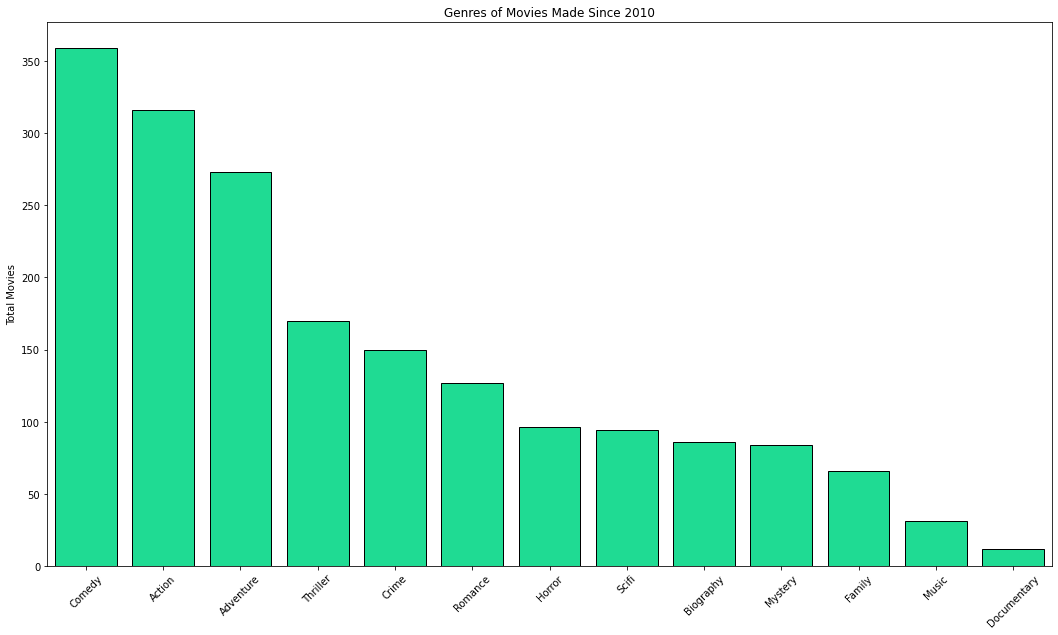

In [21]:
#First graph to show how many movies are made in each genre
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x=Genres_i, y=Genres, edgecolor='black', linewidth=1, color='mediumspringgreen')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Total Movies')
ax.set_title("Genres of Movies Made Since 2010");

<ipython-input-22-cbadfc5e4444>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=ylabels)
<ipython-input-22-cbadfc5e4444>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=ylabels1)


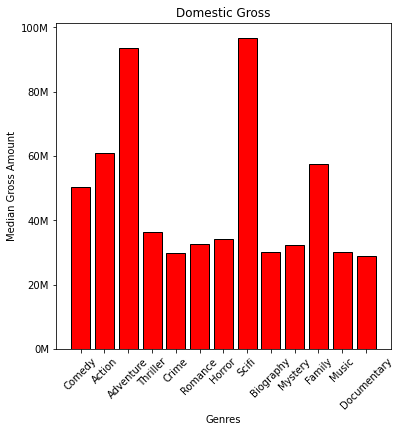

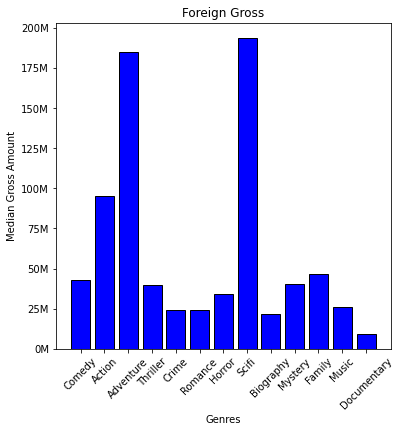

In [22]:
#Graph out the domestic gross for each genre. 
fig, ax = plt.subplots(figsize=(6,6))
ax.bar(x=Genres_i, height=DomGrossMed,  color='Red', edgecolor='black')
ax.tick_params(axis='x', rotation=45);
ylabels = ['0M', '20M', '40M', '60M', '80M', '100M']
ax.set_yticklabels(labels=ylabels)
ax.set_title('Domestic Gross')
ax.set_ylabel('Median Gross Amount')
ax.set_xlabel('Genres')

#Graph out the foreign gross for each genre. 
fig, ax = plt.subplots(figsize=(6,6))
ax.bar(x=Genres_i, height=ForGrossMed,  color='Blue', edgecolor='black')
ax.tick_params(axis='x', rotation=45, )
ylabels1 = ['0M', '25M', '50M', '75M', '100M', '125M', '150M', '175M', '200M']
ax.set_yticklabels(labels=ylabels1)
ax.set_title('Foreign Gross')
ax.set_ylabel('Median Gross Amount')
ax.set_xlabel('Genres');

<ipython-input-23-5ea757cb1da1>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=ylabelsw)


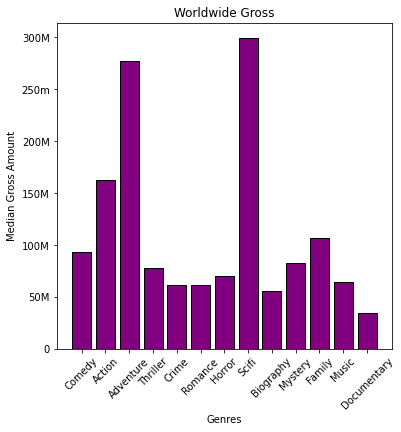

In [23]:
#Graph out the wolrdwide gross for each genre. 
fig, ax = plt.subplots(figsize=(6,6))
ax.bar(x=Genres_i, height=WorldGrossMed,  color='Purple', edgecolor='black', linewidth=1)
ylabelsw = ['0', '50M', '100M', '150M', '200M', '250m', '300M'] 
ax.set_yticklabels(labels=ylabelsw)
ax.tick_params(axis='x', rotation=45);
ax.set_title('Worldwide Gross')
ax.set_ylabel('Median Gross Amount')
ax.set_xlabel('Genres');

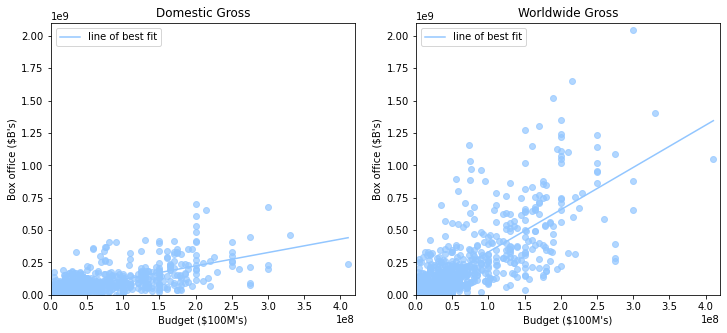

In [24]:
#side by side plots w/ same y axis: domestic vs global
#This shows that movies which transcended cultural and geographical barriers paid off in a big way.
#Much of the box office revenue generated by successful movies came from abroad.
#Production budget and world wide gross have a r value of 0.765.
#Production budget and domestic gross have a r value of 0.677.
#Worldwide gross and domestic gross have a r value of 0.936.

plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
x = BigFrame['production_budget']
y = BigFrame['domestic_gross_x']

ax[0].scatter(x, y, alpha = 0.7)
ax[0].set_title('Domestic Gross')
ax[0].set_xlabel("Budget ($100M's)")
ax[0].set_ylabel("Box office ($B's)")
ax[0].set_xlim([0, 420000000])
ax[0].set_ylim([0, 2100000000])
ax[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), label = 'line of best fit')
ax[0].legend(loc = "upper left");

wwx = BigFrame['production_budget']
wwy = BigFrame['worldwide_gross']

ax[1].scatter(wwx, wwy, alpha = 0.7)
ax[1].set_title('Worldwide Gross')
ax[1].set_xlabel("Budget ($100M's)")
ax[1].set_ylabel("Box office ($B's)")
ax[1].set_xlim([0, 420000000])
ax[1].set_ylim([0, 2100000000])
ax[1].plot(np.unique(wwx), np.poly1d(np.polyfit(wwx, wwy, 1))(np.unique(wwx)), label = 'line of best fit')
ax[1].legend(loc = "upper left");

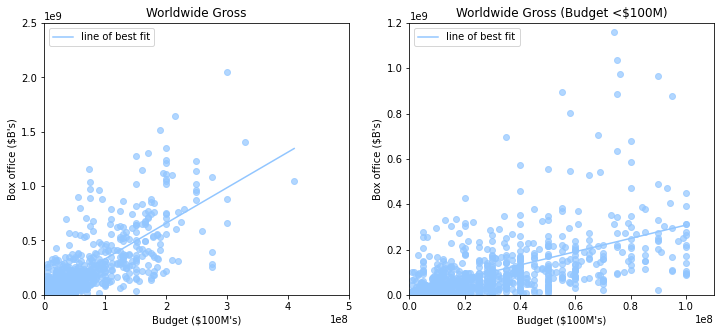

In [25]:
#plot -- Budget & Worldwide Gross, overview
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
wwx = BigFrame['production_budget']
wwy = BigFrame['worldwide_gross']

#first graph, worldwide gross all values
ax[0].scatter(wwx, wwy, alpha = 0.7)
ax[0].set_title('Worldwide Gross')
ax[0].set_xlabel("Budget ($100M's)")
ax[0].set_ylabel("Box office ($B's)")
ax[0].set_xlim([0, 500000000])
ax[0].set_ylim([0, 2500000000])
ax[0].plot(np.unique(wwx), np.poly1d(np.polyfit(wwx, wwy, 1))(np.unique(wwx)), label = 'line of best fit')
ax[0].legend(loc = "upper left");

#new df BigFrame100 for production budget movies under $100M
BigFrame100 = BigFrame[BigFrame['production_budget'] <= 100000000]
x100 = BigFrame100['production_budget']
ww100 = BigFrame100['worldwide_gross']

#second graph, Budget < $100M
ax[1].scatter(x100, ww100, alpha = 0.7)
ax[1].set_title('Worldwide Gross (Budget <$100M)')
ax[1].set_xlabel("Budget ($100M's)")
ax[1].set_ylabel("Box office ($B's)")
ax[1].set_xlim([0, 110000000])
ax[1].set_ylim([0, 1200000000])
ax[1].plot(np.unique(x100), np.poly1d(np.polyfit(x100, ww100, 1))(np.unique(x100)), label = 'line of best fit')
ax[1].legend(loc = "upper left");

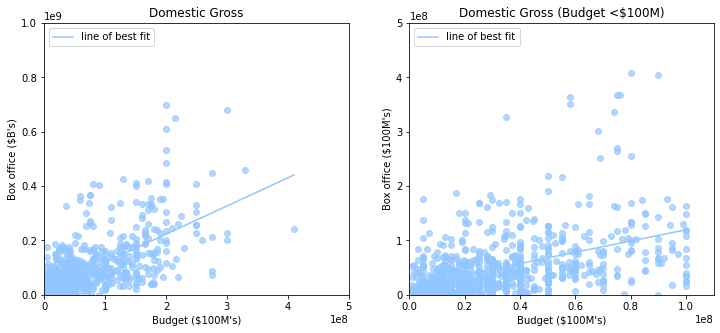

In [26]:
#plot -- Budget & Domestic Gross, overview
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
x = BigFrame['production_budget']
y = BigFrame['domestic_gross_x']

#first graph, domestic gross all values
ax[0].scatter(x, y, alpha = 0.7)
ax[0].set_title('Domestic Gross')
ax[0].set_xlabel("Budget ($100M's)")
ax[0].set_ylabel("Box office ($B's)")
ax[0].set_xlim([0, 500000000])
ax[0].set_ylim([0, 1000000000])
ax[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), label = 'line of best fit')
ax[0].legend(loc = "upper left");

#new df BigFrame100 for production budget movies under $100M
BigFrame100 = BigFrame[BigFrame['production_budget'] <= 100000000]
x100 = BigFrame100['production_budget']
y100 = BigFrame100['domestic_gross_x']

#second graph, Budget < $100M
ax[1].scatter(x100, y100, alpha = 0.7)
ax[1].set_title('Domestic Gross (Budget <$100M)')
ax[1].set_xlabel("Budget ($100M's)")
ax[1].set_ylabel("Box office ($100M's)")
ax[1].set_xlim([0, 110000000])
ax[1].set_ylim([0, 500000000])
ax[1].plot(np.unique(x100), np.poly1d(np.polyfit(x100, y100, 1))(np.unique(x100)), label = 'line of best fit')
ax[1].legend(loc = "upper left");

* These graphs demonstrate the correlation between budget and box office performance domestically and worldwide.
* Geographically transcendant films with a budget of <100M had the greatest ROI (%).
* Movies with higher budgets brought in the largest profit margins.

Next, we look to see if seasonality plays a role in the movie industry.
In order to model this data, we had to first create new columns to represent the different months within a year.
We then iterated through our old dataset and populated our new 'months_df' dataset to find the frequency.

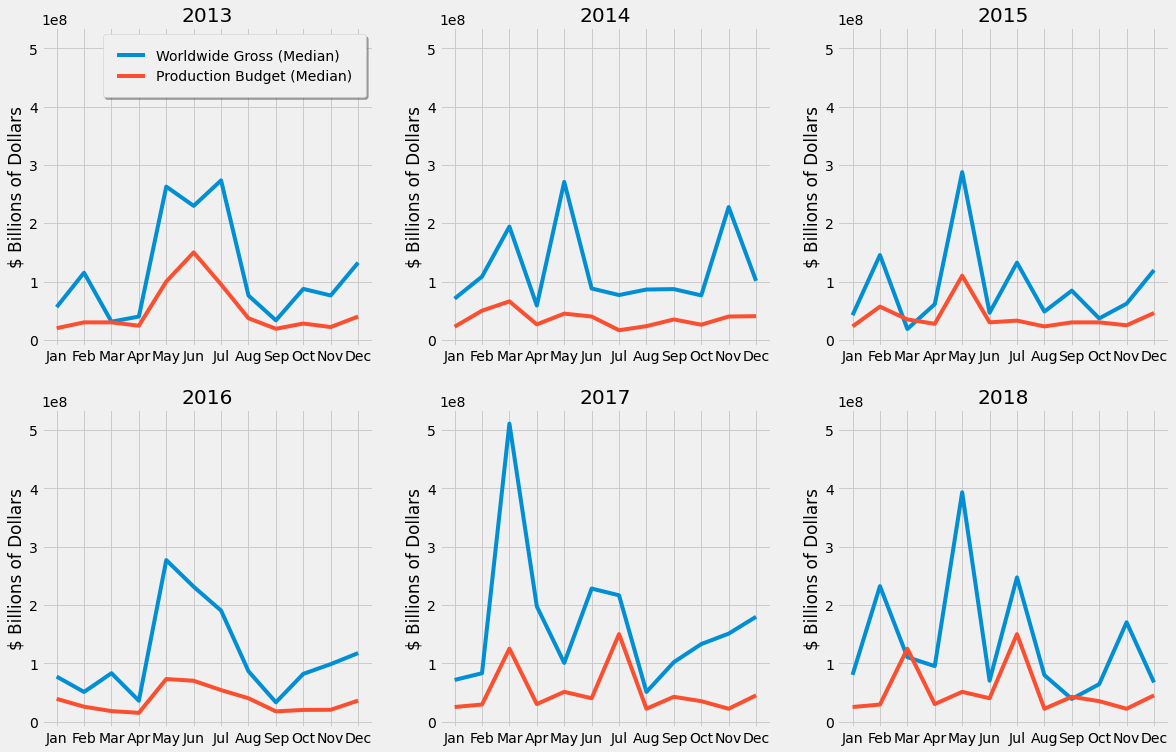

In [27]:
# Initialize 6 figures in one plot
# Set x to 'months' that we initialized above
# Plot correct year and labels on all 6 graphs
# Make them all share the same Y-axis
# Create a Legend for ease of reading

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(2, 3, figsize = (18, 12))
x= months

ax[0,0].plot(x, median_gross2013, label = 'Worldwide Gross (Median)')
ax[0,0].plot(x, median_produc2013, label = 'Production Budget (Median)')
ax[0,0].set_title('2013')
ax[0,0].set_ylabel('$ Billions of Dollars')
ax[0,0].sharey(ax[1, 2])

ax[0,1].plot(x, median_gross2014)
ax[0,1].plot(x, median_produc2014)
ax[0,1].set_title('2014')
ax[0,1].set_ylabel('$ Billions of Dollars')
ax[0,1].sharey(ax[1, 2])

ax[0,2].plot(x, median_gross2015)
ax[0,2].plot(x, median_produc2015)
ax[0,2].set_title('2015')
ax[0,2].set_ylabel('$ Billions of Dollars')
ax[0,2].sharey(ax[1, 2])

ax[1,0].plot(x, median_gross2016)
ax[1,0].plot(x, median_produc2016)
ax[1,0].set_title('2016')
ax[1,0].set_ylabel('$ Billions of Dollars')
ax[1,0].sharey(ax[1, 2])

ax[1,1].plot(x, median_gross2017)
ax[1,1].plot(x, median_produc2017)
ax[1,1].set_title('2017')
ax[1,1].set_ylabel('$ Billions of Dollars')
ax[1,1].sharey(ax[1, 2])

ax[1,2].plot(x, median_gross2018, label = 'Worldwide Gross')
ax[1,2].plot(x, median_produc2017, label = 'Production Budget')
ax[1,2].set_title('2018')
ax[1,2].set_ylabel('$ Billions of Dollars');

ax[0,0].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

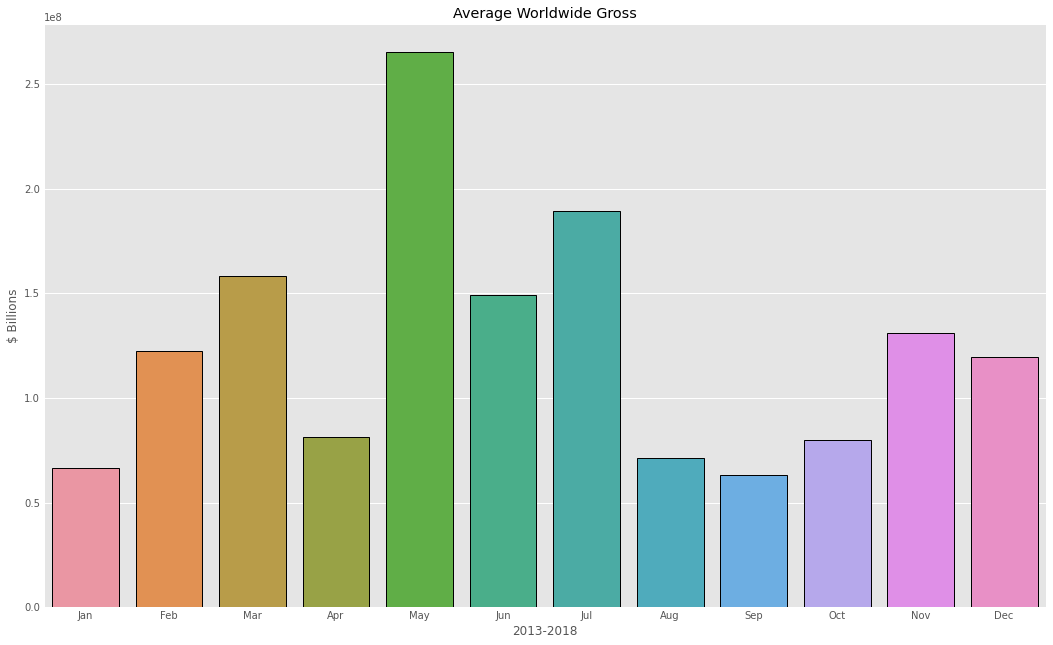

In [28]:
# Plot the average of the past 6 years
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (16, 10))
x = months
y = average_gross
sns.barplot(x=x, y=y, edgecolor = 'black', linewidth=1)
ax.set_title('Average Worldwide Gross')
ax.set_xlabel('2013-2018')
ax.set_ylabel('$ Billions');

In [29]:
# Create a months dataframe to filter results per month
column_names = months
a = np.zeros(shape=(1,12), dtype = int)
df_months = pd.DataFrame(a, columns = column_names)

# Declare new dataframe and order it as in the calender
df_months_values = BigFrame
df_months_values['month'] = pd.Categorical(df_months_values['month'], categories=months, ordered=True)
df_months_values = df_months_values['month'].sort_values()
df_months_values = list(df_months_values)

# Count the frequency of each month
for x in BigFrame['month']:
    if x in column_names:
        df_months[x] += 1
        
# Get the values from this function and copy them below *here*
list(df_months.value_counts().index)

[(70, 65, 82, 66, 68, 83, 84, 76, 84, 93, 106, 102)]

In [30]:
# Initialize y for graph
#y = [*here*]
y = [69, 61, 81, 65, 68, 82, 82, 76, 83, 92, 106, 102]

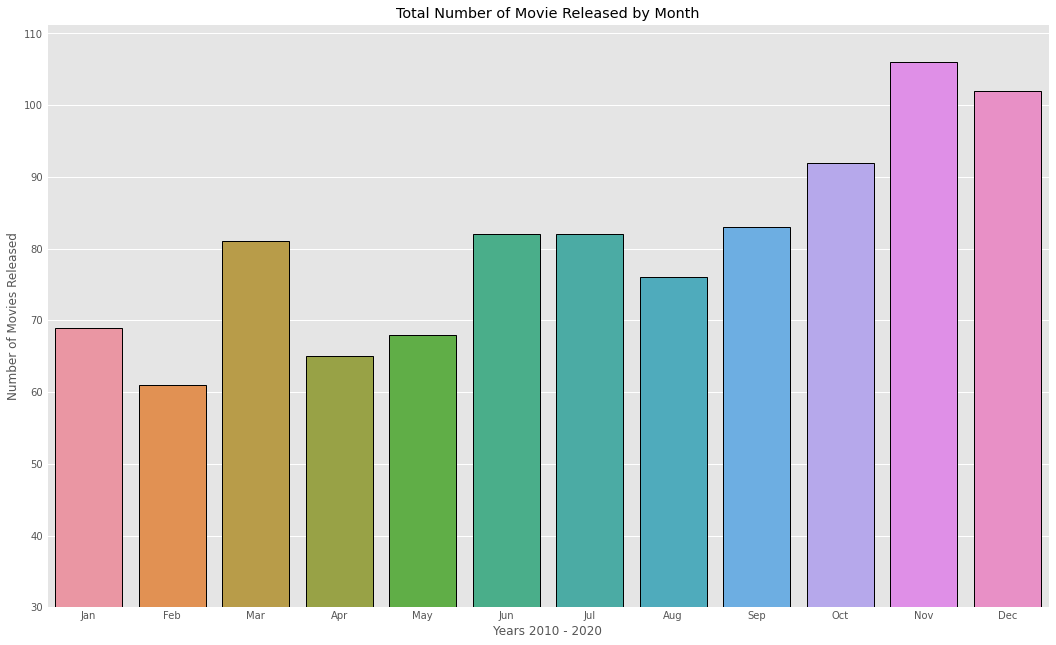

In [31]:
# Back to working with master dataframe 'BigFrame'
# Plot the total number of movies released each month
# Set y = 20 so graph is better represented
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (16, 10))
x = months
sns.barplot(x=x, y=y, edgecolor = 'black', linewidth=1);
ax.set_ylim(bottom=30)
ax.set_title('Total Number of Movie Released by Month')
ax.set_xlabel('Years 2010 - 2020')
ax.set_ylabel('Number of Movies Released');

* The window with the least competition is in the first half of the year (Jan-Jun)
* This distribution shows that movie production companies release more movies later in the year.
* Because of the data showing that movies do well during the summer, namely May-Jul, we can conclude that
* the best time to release our blockbuster movie is in May.

## Evaluation

* Releasing our film during May is ideal. History has shown that May returns the greatest revenue income for large production movies. With other movie competition not being so high in the beginning half of the year, May presents itself as the most ideal opportunity to debut our blockbuster film. 
* Genres 'Adventure' and 'Sci-fi' returns the highest median gross for movies within our dataset. 'Family' does well domestically, but not too well internationally. 'Action' is also a consistent genre that performs better than average.
* Not many production companies are creating Sci-fi films even though they are in high demand. This creates the perfect opportunity for our team.
* More successful films were able to reach a huge global audience. These films transcended cultural and geographical barriers.
* Higher budget movies did better internationally and domestically.
* Geographically transcendant films with a budget of <100M had the greatest ROI.
* Movies with higher budgets (150M+) brought in the largest profit margins.
* We are confident that our results would generalize for all movie data, assuming inflation-adjusted values and technological advancements. We are confident that this model gives a good guideline of where Microsoft should go when seeking to maximize ROI or profit margin.

## Conclusions
* Any skepticism in our data or how we could further explore our dataset (more potentially relevant comparisons)

* Sample was 967 movies, ideally we would want that number to be larger.

* Go further in depth about how much Sci-Fi and Adventure movies are spending (production_budget) in order to get good returns as shown in Visual 1.

* We would recommend the business to pursue universally acceptable themes. We would recommend the business to either stick inside the 20M-100M budget range if their objective is ROI or we would recommend the business to exceed 150M budget if their objective is to maximize profit margin.

* In the future, it would be helpful to perform NLP analysis on reviews to see what subject matter appealed or repealed viewers.
